# AI-Generated Text Detection - Baseline Model

In [10]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from datasets import load_dataset
except ModuleNotFoundError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "datasets"])
    from datasets import load_dataset


## Load and Preprocess Dataset

In [21]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(
    "json",
    data_files="https://huggingface.co/datasets/Hello-SimpleAI/HC3/resolve/main/all.jsonl",
    split="train"
)

df_raw = pd.DataFrame(dataset)
df_raw.to_json("data/HC3_dataset.json")

In [11]:
from datasets import load_dataset
import pandas as pd

# Load the raw JSONL from the repo using the 'json' loader
dataset = load_dataset(
    "json",
    data_files="https://huggingface.co/datasets/Hello-SimpleAI/HC3/resolve/main/all.jsonl",
    split="train"  # there's only a single 'train' split in this JSON file
)

# Convert to pandas
df_raw = pd.DataFrame(dataset)

# Flatten lists of answers
human = pd.DataFrame({'text': sum(df_raw['human_answers'].tolist(), []), 'label': 0})
chatgpt = pd.DataFrame({'text': sum(df_raw['chatgpt_answers'].tolist(), []), 'label': 1})

df = pd.concat([human, chatgpt]).reset_index(drop=True)


## Train-Test Split

In [12]:

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


## TF-IDF Vectorization

In [13]:

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


## Train Logistic Regression Baseline Model

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11752
           1       0.95      0.91      0.93      5338

    accuracy                           0.96     17090
   macro avg       0.95      0.94      0.95     17090
weighted avg       0.96      0.96      0.96     17090



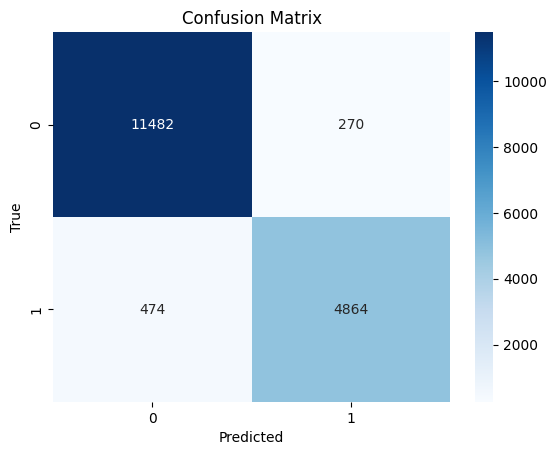

In [14]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9565
Precision: 0.9474
Recall: 0.9112
F1 Score: 0.9290


In [16]:

import joblib

joblib.dump(model, "tfidf_logreg_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Model and vectorizer saved!")


Model and vectorizer saved!


In [17]:

def predict_text(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return "ChatGPT" if prediction == 1 else "Human"

# Test example
print(predict_text("This is a sample input text."))


Human


In [18]:

feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_[0]
top_n = 15

top_positive_indices = coefficients.argsort()[-top_n:][::-1]
top_negative_indices = coefficients.argsort()[:top_n]

print("Top terms for ChatGPT:")
print([feature_names[i] for i in top_positive_indices])

print("\nTop terms for Human:")
print([feature_names[i] for i in top_negative_indices])


Top terms for ChatGPT:
['important', 'including', 'help', 'helps', 'might', 'and', 'may', 'can', 'overall', 'don', 'questions', 'or', 'doesn', 'located', 'however']

Top terms for Human:
['url_0', 'etc', 'basically', 'ca', 'only', 'my', 'most', 'do', 'but', 'thus', 'those', 'pretty', 'what', 'then', 'now']



# Final Model Summary

- **Model:** Logistic Regression with TF-IDF (5000 features).
- **Metrics:** Accuracy, Precision, Recall, and F1-score displayed above.
- **Insights:** 
  - The confusion matrix and top terms help identify patterns in AI-generated vs. human-written text.
  - The trained model and vectorizer have been saved for reuse.
